# importing data

In [1]:
"""
Simple tester for the deep3d
"""

import tensorflow as tf
import Deep3D as deep3d
import utils
import numpy as np
import os
import os.path
import h5py
import matplotlib as plt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
inria_file = '/a/data/deep3d_data/inria_data.h5'
h5f = h5py.File(inria_file,'r')

X_train = h5f['X_0'][:,10:170,16:304,:]
Y_train = h5f['Y_0'][:,10:170,16:304,:]
X_val = h5f['X_0'][:,1:170,16:304,:]
Y_val = h5f['Y_0'][:,1:170,16:304,:]
    
h5f.close()
print X_train.shape

(500, 160, 288, 3)


In [4]:
num_batches = 50
batchsize = 30


config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction= 0.9

#with tf.device('/cpu:0'):
with tf.device('/gpu:0'):  
    sess = tf.Session(config=config)

    images = tf.placeholder(tf.float32, [batchsize, 160, 288, 3])
    true_out = tf.placeholder(tf.float32, [batchsize, 160, 288, 3])
    
    train_mode = tf.placeholder(tf.bool)

    net = deep3d.Deep3Dnet('./vgg19.npy')
    net.build(images, train_mode)

    #print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    print 'var count:'
    print(net.get_var_count())
        
    sess.run(tf.global_variables_initializer())
    
    # simple 1-step training
    cost = tf.reduce_sum((net.prob - true_out) ** 2)
    train = tf.train.GradientDescentOptimizer(0.002).minimize(cost)
    
    print "start training"
    for i in xrange(num_batches):
        image_mask = np.random.choice(X_train.shape[0],batchsize)
        images_in = X_train[image_mask,:,:,:]
        labels_in = Y_train[image_mask,:,:,:]
        _, cost_val = sess.run([train,cost], feed_dict={images: images_in, true_out: labels_in, train_mode: True})
        print 'cost:' + str(cost_val)
        
    net.save_npy(sess)
    

var count:
138408071
start training
cost:138407.0
cost:51311.1
cost:51274.1
cost:40649.7
cost:33883.2
cost:32355.2
cost:31507.5
cost:41934.9
cost:57709.9
cost:41885.1
cost:35446.6
cost:34616.6
cost:32058.7
cost:33921.2
cost:32615.0
cost:36271.6
cost:33743.5
cost:35755.3
cost:31101.8
cost:32360.9
cost:32028.9
cost:33081.2
cost:33804.1
cost:38954.3
cost:31414.5
cost:31736.6
cost:33999.4
cost:32432.7
cost:29374.8
cost:35241.4
cost:37266.4
cost:30410.8
cost:33878.6
cost:33371.3
cost:34834.3
cost:34504.9
cost:32176.7
cost:35222.4
cost:33345.1
cost:33639.4
cost:36286.1
cost:34327.7
cost:34344.3
cost:33913.5
cost:32427.0
cost:32979.0
cost:34097.7
cost:34593.3
cost:36301.8
cost:36396.0
('file saved', './deep3d-save.npy')


In [5]:
del net

# Test
test_img = np.expand_dims(X_train[0], axis = 0)
test_ans = Y_train[0]

with tf.device("/gpu:0"):
    images = tf.placeholder(tf.float32, [1, 160, 288, 3])
    net = deep3d.Deep3Dnet('./deep3d-save.npy')
    net.build(images, train_mode)
    sess.run(tf.global_variables_initializer())
    res, mask, up_3 = sess.run([net.prob, net.mask, net.up_3], feed_dict={images: test_img, train_mode: False})


--- Input ---


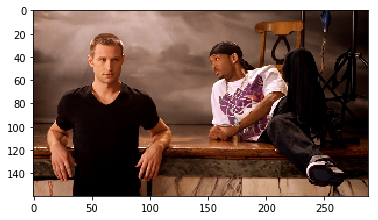

--- GT ---


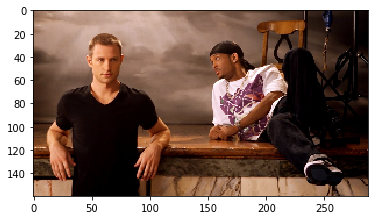

--- Our result ---


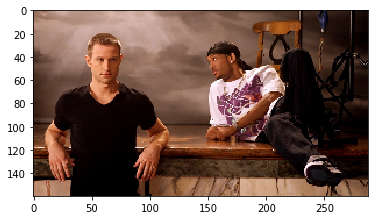

In [6]:
from matplotlib import pyplot
pyplot.figure()

print "--- Input ---"
pyplot.imshow(test_img[0])
pyplot.show()

print "--- GT ---"
pyplot.imshow(test_ans)
pyplot.show()

print "--- Our result ---"
pyplot.imshow(res[0])
pyplot.show()

pyplot.imsave('1.jpeg', test_img[0])
pyplot.imsave('2.jpeg', res[0])

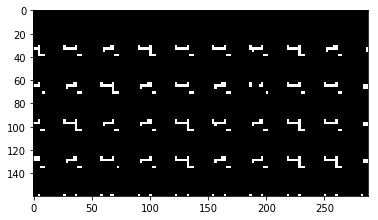

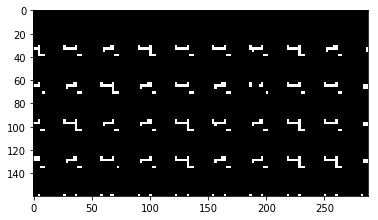

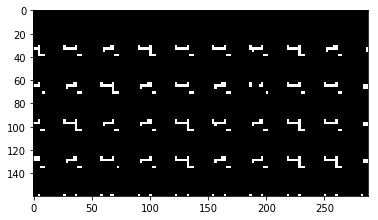

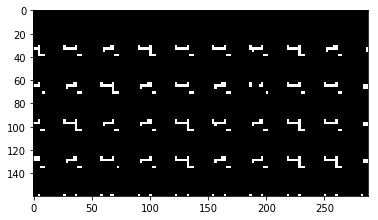

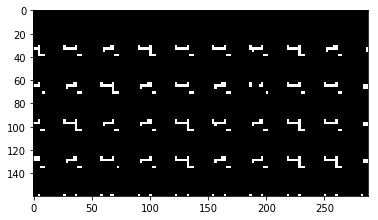

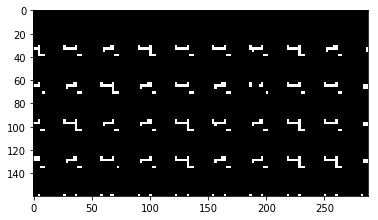

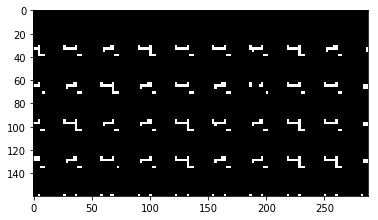

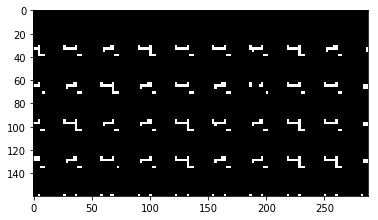

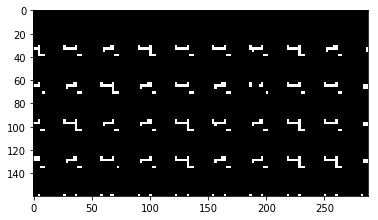

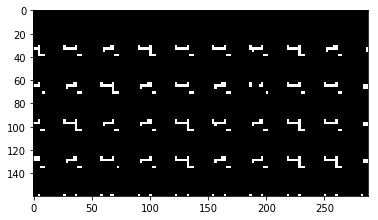

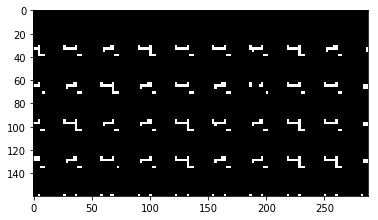

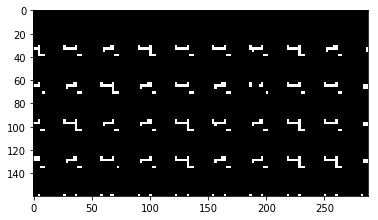

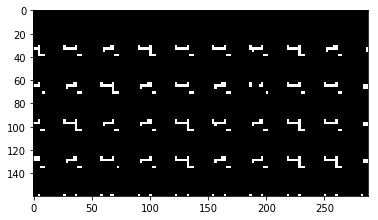

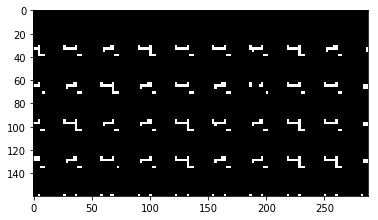

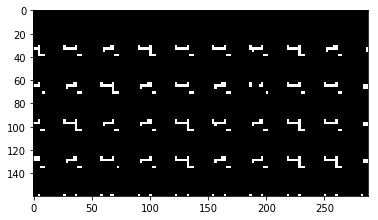

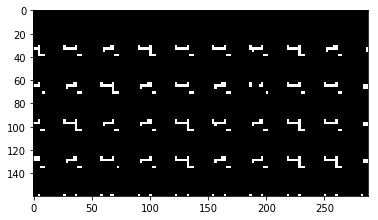

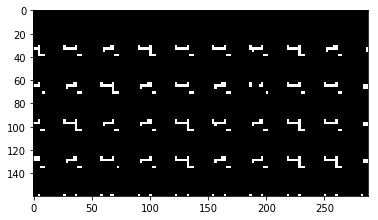

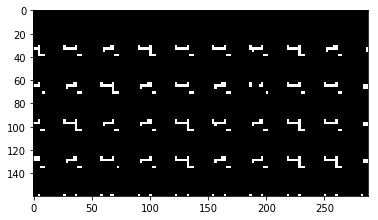

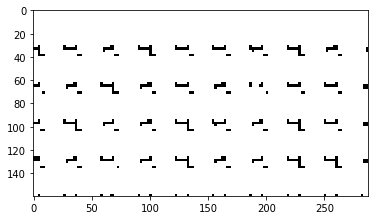

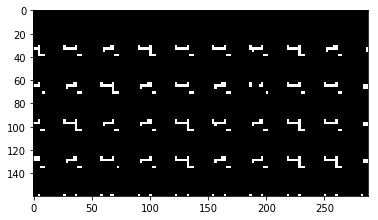

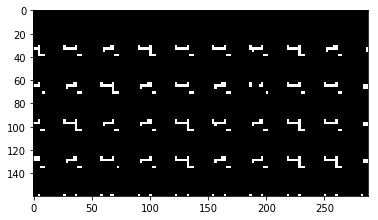

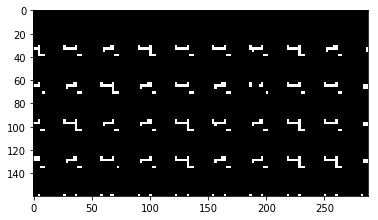

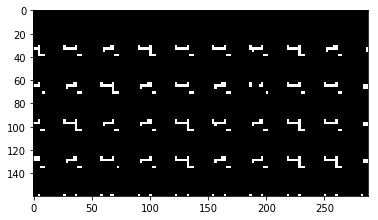

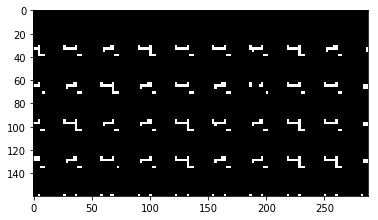

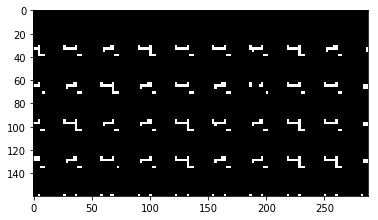

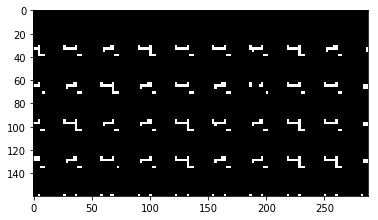

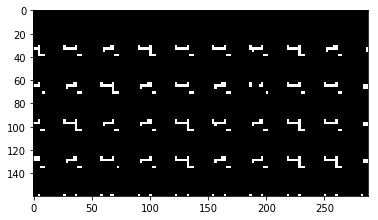

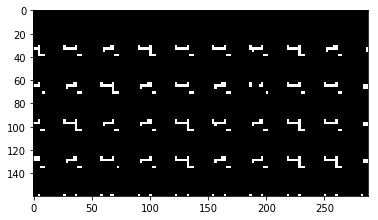

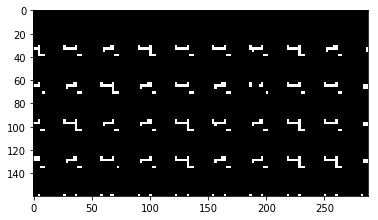

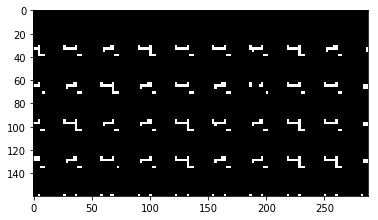

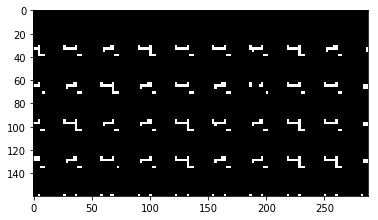

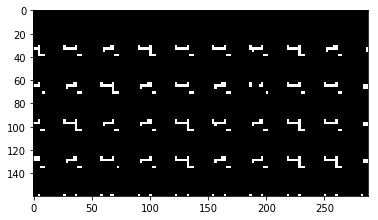

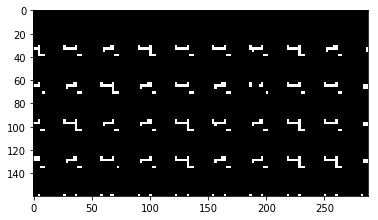

In [7]:
for i in range(33):
    pyplot.imshow(mask[0,:,:,i], cmap='gray')
    pyplot.show()

In [8]:
max_shift_channel = np.argmax(mask,axis = 3)
max_shift_channel[0]

array([[18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       ..., 
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18]])

In [13]:
mask[0,:,:,18]

1.0

In [11]:
test_img[0]

array([[[ 0.59607843,  0.43529412,  0.36470588],
        [ 0.61568627,  0.4627451 ,  0.39607843],
        [ 0.64313725,  0.49803922,  0.43529412],
        ..., 
        [ 0.08235294,  0.03921569,  0.01568627],
        [ 0.08235294,  0.03921569,  0.02352941],
        [ 0.0745098 ,  0.03137255,  0.02352941]],

       [[ 0.56470588,  0.41960784,  0.34901961],
        [ 0.58823529,  0.44313725,  0.37254902],
        [ 0.58823529,  0.44313725,  0.37254902],
        ..., 
        [ 0.08235294,  0.03921569,  0.02352941],
        [ 0.08235294,  0.03921569,  0.03137255],
        [ 0.08627451,  0.03137255,  0.01960784]],

       [[ 0.54901961,  0.40392157,  0.33333333],
        [ 0.56078431,  0.41568627,  0.34509804],
        [ 0.57254902,  0.42745098,  0.35686275],
        ..., 
        [ 0.08627451,  0.03921569,  0.03921569],
        [ 0.08235294,  0.02745098,  0.02745098],
        [ 0.08235294,  0.02745098,  0.01568627]],

       ..., 
       [[ 0.73333333,  0.5372549 ,  0.43137255],
        